In [78]:
import tensorflow as tf
from sklearn.model_selection import KFold
import numpy as np
import logging
from datetime import datetime
import dataclasses
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection as ms
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import os
from tensorflow.keras.callbacks import TensorBoard

tf.debugging.set_log_device_placement(False)

# datetime as filename for logging
now = datetime.now()
date_time_string = now.strftime("%Y-%m-%d_%H-%M-%S")

logging.basicConfig(level=logging.INFO, filename = f"{date_time_string}.txt", filemode='a')
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [79]:
from dataclasses import dataclass
# Static Parameters
@dataclass
class Parameters():
    batch_size: int = 128
    epochs: int = 2
    verbosity: str = "auto"
    step_size: int = 374
    number_folds: int = 2
    output_size: int = 6

In [80]:
df = pd.read_csv("Alle_Messungen_trimmed.csv") 
df.head(1)

,Unnamed: 0,time,Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,Orientation_qx,Orientation_qy,Orientation_qz,id,user,class,id_combined
0,1,2023-02-27 15:02:17.156,0.0,9.722,1.278,0.0,0.0,0.0,0.0,0.0,0.0,-0.21775,-0.719579,0.631111,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen


In [81]:
# convert the string time column to datetime
epoch = pd.Timestamp('1970-01-01')

df['time'] = pd.to_datetime(df['time'])
df['time'] = (df['time'] - epoch).apply(lambda x: int(x.total_seconds() * 1000))

In [82]:
df = df.drop(columns=["id", "user", "id_combined"])
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# get all types of the df
le = LabelEncoder()
df["class"] = le.fit_transform(df["class"])

In [83]:
# Set the window size and step size
window_size = 300
step_size = 100

# Reshape X to 2D format (samples, features)
X = df.values[:, 1:13]

# Define y
y = df["class"].values

# Create a sliding window of X with the specified window and step sizes
X_windows = np.array([X[i:i+window_size,:] for i in range(0,X.shape[0]-window_size+1,step_size)])

# Reshape X_windows to 3D format (samples, timesteps, features)
timesteps = X_windows.shape[1]
n_features = X_windows.shape[2]
X_windows = X_windows.reshape(-1, timesteps, n_features)

# Create the corresponding y labels for the sliding windows
y_windows = np.array([y[i+window_size-1] for i in range(0,X.shape[0]-window_size+1,step_size)])
y_windows = to_categorical(y_windows, num_classes=6)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_windows, y_windows, test_size=0.2, random_state=42, stratify=y_windows)


In [84]:
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2497481, 12),
 (2497481,),
 (19977, 300, 12),
 (19977, 6),
 (4995, 300, 12),
 (4995, 6))

In [85]:
x_train = X_train
x_test = X_test
y_train = y_train
y_test = y_test

In [86]:
# Something like this as first Model
def create_model_1():
    model = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu', input_shape=(12,)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(8, activation='relu', input_shape=(12,)),
            tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    return model


# Something like this as second Model
def create_model_2():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((-1, 12), input_shape=(12,)),
        tf.keras.layers.Conv1D(32, 5, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv1D(16, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    return model

# Something like this as Third Model
def create_model_3():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((-1, 12), input_shape=(12,)),
        tf.keras.layers.Conv1D(32, 5, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv1D(16, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    return model

def create_model_4():
    model = tf.keras.Sequential([
        # Add a 1D convolutional layer
        tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding='same', input_shape=(timesteps, n_features)),
        
        # Add LSTM layer
        tf.keras.layers.LSTM(100),

        # Add a dense output layer
        tf.keras.layers.Dense(6, activation='softmax')  # Change activation function based on the nature of the output
    ])
    model.compile(optimizer='adam',   loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])  
    return model

In [88]:
best_model_history = None  # Keep track of the best model's history
model_histories = []
# Perform cross-validation
models = [create_model_4]
best_model = None
num_folds = Parameters.number_folds
kfold = KFold(n_splits=num_folds, shuffle=False)
fold_acc_scores = []

for i, (train, test) in enumerate(kfold.split(x_train, y_train)):
    logging.info(f'Fold {i+1}')
    train_x, train_y = x_train[train], y_train[train]
    test_x, test_y = x_train[test], y_train[test]
    
    fold_histories = []

    
    for j, model_creator in enumerate(models):
        model = model_creator()
        logging.info(f'Model {j+1}')
        history = model.fit(train_x, train_y, epochs=Parameters.epochs, batch_size=Parameters.batch_size, validation_data=(test_x, test_y), verbose=Parameters.verbosity)
        test_loss, acc, prec, recal = model.evaluate(test_x, test_y, verbose=Parameters.verbosity)
        logging.info(f'Validation accuracy: {acc}')
        
        fold_histories.append(history.history)
        
        for epoch in range(Parameters.epochs):
            # Log accuracy after each epoch
            acc_epoch = history.history['val_accuracy'][epoch]
            logging.info(f'Epoch {epoch + 1}, Validation accuracy: {acc_epoch}')
        fold_acc_scores.append((i, j, acc))
        
        if best_model_history is None or acc > best_model_acc:
            best_model_history = history
            best_model = model  # Store the trained model instance
            best_model_acc = acc
    
    model_histories.append(fold_histories)

# Find the best model
best_model_index = np.argmax([score[2] for score in fold_acc_scores])
best_fold_idx, best_model_idx, _ = max(fold_acc_scores, key=lambda x: x[2])
best_model_history = model_histories[best_fold_idx][best_model_idx]


#ogging.info(fold_acc_scores)
#logging.info(best_model_index)
#(best_fold, best_model_index, best_model_acc) = fold_acc_scores[best_model_index]
#best_model = models[best_model_index]
#logging.info(f'fold acc score: {fold_acc_scores}')
#logging.info(f'Best model is model {best_model_index+1}')

# Evaluate the best model on the test set
test_loss, test_acc, test_prec, test_recall = best_model.evaluate(x_test, y_test)
logging.info(f'Test accuracy {test_acc}')

Epoch 1/2
79/79 [==============================] - 150s 2s/step - loss: 1.0516 - accuracy: 0.6292 - precision_6: 0.8521 - recall_6: 0.3702 - val_loss: 0.7610 - val_accuracy: 0.7310 - val_precision_6: 0.8561 - val_recall_6: 0.5680
Epoch 2/2
313/313 [==============================] - 21s 66ms/step - loss: 0.4782 - accuracy: 0.8489 - precision_6: 0.8992 - recall_6: 0.7898
Epoch 1/2
79/79 [==============================] - 143s 2s/step - loss: 1.0631 - accuracy: 0.6125 - precision_7: 0.8532 - recall_7: 0.3597 - val_loss: 0.7349 - val_accuracy: 0.7815 - val_precision_7: 0.8830 - val_recall_7: 0.6057
Epoch 2/2
157/157 [==============================] - 11s 71ms/step - loss: 0.4762 - accuracy: 0.8589 - precision_7: 0.9117 - recall_7: 0.7954


[1.0631083250045776, 0.5947047472000122]


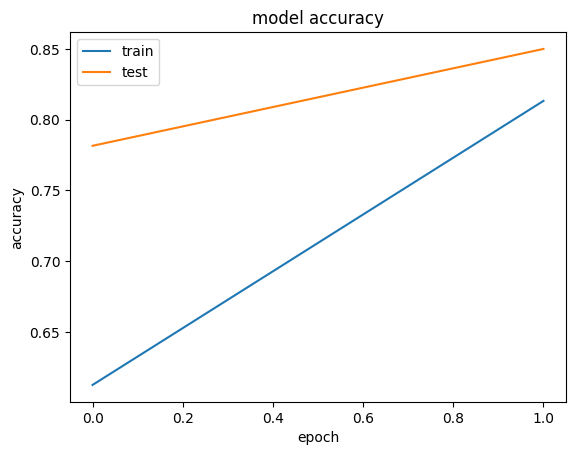

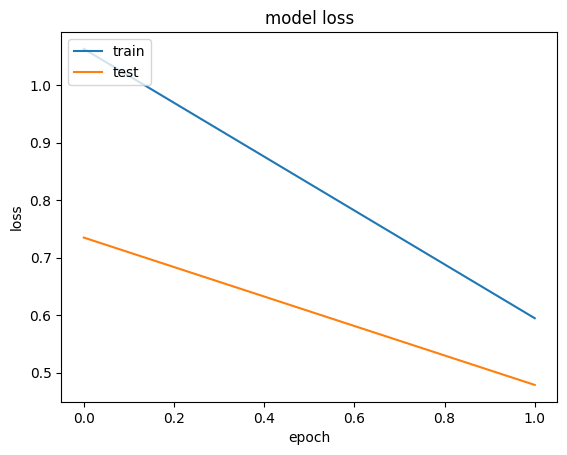

In [89]:

import matplotlib.pyplot as plt
import numpy as np

print(best_model_history['loss'])
# summarize history for accuracy
plt.plot(best_model_history['accuracy'])
plt.plot(best_model_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(best_model_history['loss'])
plt.plot(best_model_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [90]:
df_yvo = pd.read_csv("Yvo_Messung_Velo.csv")
df_yvo = df_yvo.drop(columns=["id", "user", "id_combined"])
# convert the string time column to datetime
epoch = pd.Timestamp('1970-01-01')
df_yvo['time'] = pd.to_datetime(df_yvo['time'])
df_yvo['time'] = (df_yvo['time'] - epoch).apply(lambda x: int(x.total_seconds() * 1000))
df_yvo.drop(['Unnamed: 0'], axis=1, inplace=True)
# get all types of the df
le = LabelEncoder()
df_yvo["class"] = le.fit_transform(df_yvo["class"])

In [91]:
# Set the window size and step size
window_size = 300
step_size = 100

# Reshape X to 2D format (samples, features)
X = df_yvo.values[:, 1:13]

# Create a sliding window of X with the specified window and step sizes
X_windows = np.array([X[i:i+window_size,:] for i in range(0,X.shape[0]-window_size+1,step_size)])

# Reshape X_windows to 3D format (samples, timesteps, features)
timesteps = X_windows.shape[1]
n_features = X_windows.shape[2]
X_windows = X_windows.reshape(-1, timesteps, n_features)

y_pred_probs = best_model.predict(X_windows)

# Get the predicted class labels for each input window
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Print the predicted class labels
# get the median of the predicted labels
sol = np.median(y_pred_labels)

class_counts = np.bincount(y_pred_labels)
for i, count in enumerate(class_counts):
    print(f"Class {i} count: {count}")


  33/1944 [..............................] - ETA: 1:59

KeyboardInterrupt: 

In [ ]:
sol

3.0